# Department of Transportation - Oil Spill Mapping

In [1]:
# Dependencies and Setup
import pandas as pd
import requests
import gmaps
import openpyxl
import folium
import json
import gmaps.datasets
import numpy as np
import re
from datetime import date, datetime
from django.core.serializers.json import DjangoJSONEncoder
from dataprep.clean import clean_lat_long
from dataprep.clean import validate_lat_long
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# import descartes
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas

%matplotlib inline
%matplotlib notebook

# Import API key
# from config import g_map

# Configure gmaps
# gmaps.configure(api_key=g_map)

NumExpr defaulting to 8 threads.
PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


## Bring in 2010 - Present Data

In [3]:
# 1. Read the Data_Columns_and_spills into a DataFrame. All sheets
# Unedited excel files
xlfile_2010 = pd.ExcelFile("Data_columns_and_spills.xlsx", engine='openpyxl')
spill2010_df = xlfile_2010.parse('2010-Present') #'2010-Present' is the sheet name in the excel file
#spill2010_df is all data all columns

In [4]:
spill2010_df.dtypes


REPORT_RECEIVED_DATE    datetime64[ns]
IYEAR                            int64
REPORT_NUMBER                    int64
SUPPLEMENTAL_NUMBER              int64
REPORT_TYPE                     object
                             ...      
AUTHORIZER_NAME                 object
AUTHORIZER_TITLE                object
AUTHORIZER_TELEPHONE            object
AUTHORIZER_EMAIL                object
NARRATIVE                       object
Length: 588, dtype: object

In [5]:
# formatting dataframe for mapping display. 
# Have to change datetime to string for json conversion
spill2010_df["REPORT_RECEIVED_DATE"] = spill2010_df["REPORT_RECEIVED_DATE"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["LOCAL_DATETIME"] = spill2010_df["LOCAL_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["NRC_RPT_DATETIME"] = spill2010_df["NRC_RPT_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["SHUTDOWN_DATETIME"] = spill2010_df["SHUTDOWN_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["RESTART_DATETIME"] = spill2010_df["RESTART_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["INCIDENT_IDENTIFIED_DATETIME"] = spill2010_df["INCIDENT_IDENTIFIED_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["ON_SITE_DATETIME"] = spill2010_df["ON_SITE_DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S')
spill2010_df["PREPARED_DATE"] = spill2010_df["PREPARED_DATE"].dt.strftime('%Y-%m-%d %H:%M:%S')
# Creating additional columns of UNINTENTIONAL_RELEASE_BBLS and PRPTY as a string for popup but still need 
# UNINTENTIONAL_RELEASE_BBLS and PRPTY as float for plotting
spill2010_df["UNINTENTIONAL_RELEASE_BBLS_STR"] = spill2010_df["UNINTENTIONAL_RELEASE_BBLS"].map("{:,.2f}".format)
spill2010_df["PRPTY_STR"] = spill2010_df["PRPTY"].map("${:,.0f}".format)



In [6]:
spill2010_df["COMPONENT_AGE(YEARS)"] = (spill2010_df["IYEAR"] - spill2010_df["INSTALLATION_YEAR"]) + 1
spill2010_df.head()

,REPORT_RECEIVED_DATE,IYEAR,REPORT_NUMBER,SUPPLEMENTAL_NUMBER,REPORT_TYPE,OPERATOR_ID,NAME,OPERATOR_STREET_ADDRESS,OPERATOR_CITY_NAME,OPERATOR_STATE_ABBREVIATION,...,PREPARER_FAX,PREPARED_DATE,AUTHORIZER_NAME,AUTHORIZER_TITLE,AUTHORIZER_TELEPHONE,AUTHORIZER_EMAIL,NARRATIVE,UNINTENTIONAL_RELEASE_BBLS_STR,PRPTY_STR,COMPONENT_AGE(YEARS)
0,2018-12-10 00:00:00,2018,20180382,32252,SUPPLEMENTAL FINAL,31130,DCP MIDSTREAM,370 17TH STREET SUITE 2500,DENVER,CO,...,NaN,2019-06-07 00:00:00,JOHN PONTIOUS,MANAGER PIPELINE COMPLIANCE,405-605-3859,jdpontious@dcpmidstream.com,DCP CONTRACT LINE LOCATOR GUADALUPE VALDES PRO...,"48,400.00","$15,200,000",6.0
1,2020-11-06 00:00:00,2020,20200300,34501,ORIGINAL FINAL,32545,"DENBURY GULF COAST PIPELINES, LLC",5851 LEGACY CIRCLE SUITE 1200,PLANO,TX,...,NaN,2020-11-06 00:00:00,DAVID SHEPPARD,SENIOR VICE PRESIDENT - OPERATIONS,972-673-2038,david.sheppard@denbury.com,"ON 10/7/2020 AT 17:31, DENBURY BEGAN BLOWDOWN ...","41,177.00","$64,998",12.0
2,2015-02-24 00:00:00,2015,20150071,21327,SUPPLEMENTAL FINAL,31618,ENTERPRISE PRODUCTS OPERATING LLC,1100 LOUISIANA STREET,HOUSTON,TX,...,NaN,2016-04-21 00:00:00,MICHAEL PAVLAK,SR. COMPLIANCE SPECIALIST,713-381-5897,mjpavlak@eprod.com,AT APPROXIMATELY 9:40 A.M. C.S.T. ON JANUARY 2...,"30,565.00","$6,910,591",3.0
3,2020-09-13 00:00:00,2020,20200253,35187,SUPPLEMENTAL,2552,COLONIAL PIPELINE CO,1185 SANCTUARY PARKWAY SUITE 100,ALPHARETTA,GA,...,NaN,2021-04-17 00:00:00,MARK PIAZZA,MANAGER - PIPELINE COMPLIANCE,678-763-5911,mpiazza@colpipe.com,"ON 8/14/2020 AT 18:20, A COLONIAL EMPLOYEE WAS...","28,571.00","$64,253,139",43.0
4,2015-02-06 00:00:00,2015,20150040,20630,SUPPLEMENTAL FINAL,31618,ENTERPRISE PRODUCTS OPERATING LLC,1100 LOUISIANA STREET,HOUSTON,TX,...,NaN,2015-07-29 00:00:00,NEAL BURRELL,SR. PIPELINE COMPLIANCE SPECIALIST,713-381-3536,wnburrell@eprod.com,"ON 1/10/2015 AT 20:45 HRS, PIPELINE CONTROL DI...","27,123.00","$782,260",50.0


<IPython.core.display.Javascript object>


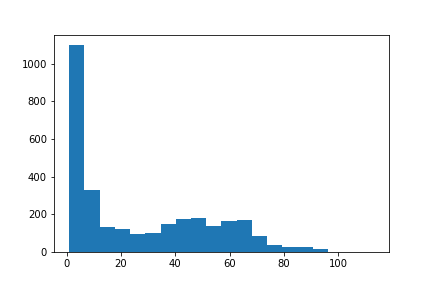

(array([1.10e+03, 3.29e+02, 1.33e+02, 1.24e+02, 9.70e+01, 9.90e+01,
        1.50e+02, 1.76e+02, 1.83e+02, 1.40e+02, 1.67e+02, 1.72e+02,
        8.40e+01, 3.60e+01, 2.70e+01, 2.50e+01, 1.60e+01, 1.00e+00,
        1.00e+00, 1.00e+00]),
 array([  1. ,   6.6,  12.2,  17.8,  23.4,  29. ,  34.6,  40.2,  45.8,
         51.4,  57. ,  62.6,  68.2,  73.8,  79.4,  85. ,  90.6,  96.2,
        101.8, 107.4, 113. ]),
 <BarContainer object of 20 artists>)

In [11]:
# Component age histrogram
plt.hist(spill2010_df['COMPONENT_AGE(YEARS)'], 20)

In [10]:
# Pulling useful columns for mapping purposes
my_columns = [
    'REPORT_NUMBER',
    'NAME',
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
    'COMMODITY_RELEASED_TYPE',
    'UNINTENTIONAL_RELEASE_BBLS',
    'UNINTENTIONAL_RELEASE_BBLS_STR',
    'ON_OFF_SHORE',
    'ONSHORE_CITY_NAME',
    'ONSHORE_COUNTY_NAME',
    'ONSHORE_STATE_ABBREVIATION',
    'SYSTEM_PART_INVOLVED',
    'INSTALLATION_YEAR',
    'COMPONENT_AGE(YEARS)',
    'CAUSE',
    'ACCIDENT_PSIG',
    'MOP_PSIG',
    'PRPTY',
    'PRPTY_STR'
]

In [11]:
# mapping columns called info2010_df
mapping_df = spill2010_df[my_columns]
# Creating another dataframe of first 100 rows called 'test' t2010_df
# Used to get map functioning and limiting API requests
# t2010_df = info2010_df[:100]
# t2010_df.to_json('test_df.json') # exports DataFrame to json for javascript and mapping functionality
# t2010_df
mapping_df

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
0,20180382,DCP MIDSTREAM,30.351556,-100.581792,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,48400.0,"48,400.00",ONSHORE,Not Within a Municipality,SUTTON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,6.0,EXCAVATION DAMAGE,1044.0,1440.0,15200000.0,"$15,200,000"
1,20200300,"DENBURY GULF COAST PIPELINES, LLC",32.628233,-90.569264,CO2 (CARBON DIOXIDE),41177.0,"41,177.00",ONSHORE,Not Within a Municipality,YAZOO COUNTY,MS,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2009.0,12.0,EQUIPMENT FAILURE,980.0,2160.0,64998.0,"$64,998"
2,20150071,ENTERPRISE PRODUCTS OPERATING LLC,40.366817,-80.584594,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,30565.0,"30,565.00",ONSHORE,COLLIERS,BROOKE,WV,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,3.0,MATERIAL FAILURE OF PIPE OR WELD,1183.0,1440.0,6910591.0,"$6,910,591"
3,20200253,COLONIAL PIPELINE CO,35.414106,-80.806185,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,28571.0,"28,571.00",ONSHORE,HUNTERSVILLE,MECKLENBURG,NC,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1978.0,43.0,MATERIAL FAILURE OF PIPE OR WELD,183.0,673.0,64253139.0,"$64,253,139"
4,20150040,ENTERPRISE PRODUCTS OPERATING LLC,28.885881,-96.433027,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,27123.0,"27,123.00",ONSHORE,Not Within a Municipality,JACKSON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1966.0,50.0,MATERIAL FAILURE OF PIPE OR WELD,922.0,1024.0,782260.0,"$782,260"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,20180006,DIXIE PIPELINE COMPANY LLC,33.362982,-83.447904,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,0.0,0.00,ONSHORE,EATONTON,PUTNAM,GA,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,NaN,NaN,EQUIPMENT FAILURE,1323.0,1440.0,8588.0,"$8,588"
4636,20180156,ENTERPRISE CRUDE PIPELINE LLC,29.741758,-95.124244,CRUDE OIL,0.0,0.00,ONSHORE,HOUSTON,HARRIS,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",NaN,NaN,INCORRECT OPERATION,0.0,0.0,0.0,$0
4637,20190001,ENBRIDGE STORAGE (CUSHING) L.L.C.,35.940630,-96.748440,CRUDE OIL,0.0,0.00,ONSHORE,CUSHING,LINCOLN,OK,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,2018.0,1.0,EQUIPMENT FAILURE,0.0,275.0,8368.0,"$8,368"
4638,20190021,"PLAINS PIPELINE, L.P.",33.916010,-98.436540,CRUDE OIL,0.0,0.00,ONSHORE,WICHITA FALLS,WICHITA,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",1949.0,70.0,INCORRECT OPERATION,0.0,0.0,2030538.0,"$2,030,538"


In [22]:
mapping_df = mapping_df.fillna('N/A')
mapping_df

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
0,20180382,DCP MIDSTREAM,30.351556,-100.581792,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,48400.0,"48,400.00",ONSHORE,Not Within a Municipality,SUTTON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,6.0,EXCAVATION DAMAGE,1044.0,1440.0,15200000.0,"$15,200,000"
1,20200300,"DENBURY GULF COAST PIPELINES, LLC",32.628233,-90.569264,CO2 (CARBON DIOXIDE),41177.0,"41,177.00",ONSHORE,Not Within a Municipality,YAZOO COUNTY,MS,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2009.0,12.0,EQUIPMENT FAILURE,980.0,2160.0,64998.0,"$64,998"
2,20150071,ENTERPRISE PRODUCTS OPERATING LLC,40.366817,-80.584594,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,30565.0,"30,565.00",ONSHORE,COLLIERS,BROOKE,WV,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,3.0,MATERIAL FAILURE OF PIPE OR WELD,1183.0,1440.0,6910591.0,"$6,910,591"
3,20200253,COLONIAL PIPELINE CO,35.414106,-80.806185,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,28571.0,"28,571.00",ONSHORE,HUNTERSVILLE,MECKLENBURG,NC,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1978.0,43.0,MATERIAL FAILURE OF PIPE OR WELD,183.0,673.0,64253139.0,"$64,253,139"
4,20150040,ENTERPRISE PRODUCTS OPERATING LLC,28.885881,-96.433027,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,27123.0,"27,123.00",ONSHORE,Not Within a Municipality,JACKSON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1966.0,50.0,MATERIAL FAILURE OF PIPE OR WELD,922.0,1024.0,782260.0,"$782,260"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,20180006,DIXIE PIPELINE COMPANY LLC,33.362982,-83.447904,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,0.0,0.00,ONSHORE,EATONTON,PUTNAM,GA,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,N/A,N/A,EQUIPMENT FAILURE,1323.0,1440.0,8588.0,"$8,588"
4636,20180156,ENTERPRISE CRUDE PIPELINE LLC,29.741758,-95.124244,CRUDE OIL,0.0,0.00,ONSHORE,HOUSTON,HARRIS,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",N/A,N/A,INCORRECT OPERATION,0.0,0.0,0.0,$0
4637,20190001,ENBRIDGE STORAGE (CUSHING) L.L.C.,35.940630,-96.748440,CRUDE OIL,0.0,0.00,ONSHORE,CUSHING,LINCOLN,OK,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,2018.0,1.0,EQUIPMENT FAILURE,0.0,275.0,8368.0,"$8,368"
4638,20190021,"PLAINS PIPELINE, L.P.",33.916010,-98.436540,CRUDE OIL,0.0,0.00,ONSHORE,WICHITA FALLS,WICHITA,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",1949.0,70.0,INCORRECT OPERATION,0.0,0.0,2030538.0,"$2,030,538"


In [12]:
mapping_dict = mapping_df.to_dict('records')
json_mapping = json.dumps(mapping_dict, indent = 4)
with open('mapping.json','w') as data:
    data.write(json_mapping)

In [23]:
corrosion_df = mapping_df.loc[(mapping_df["CAUSE"] == "CORROSION FAILURE")]
corrosion_dict = corrosion_df.to_dict('records')
json_corrosion = json.dumps(corrosion_dict, indent = 4)
with open('corrosion.json','w') as data:
    data.write(json_corrosion)
    
corrosion_df.head(5)



,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
17,20190007,"SFPP, LP",32.061560,-106.649450,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,10910.0,"10,910.00",ONSHORE,ANTHONY,DONA ANA,NM,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1964.0,55.0,CORROSION FAILURE,1073.0,1104.0,20041360.0,"$20,041,360"
26,20160325,SUNOCO PIPELINE L.P.,32.452790,-100.358620,CRUDE OIL,8600.0,"8,600.00",ONSHORE,SWEETWATER,NOLAN,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2015.0,2.0,CORROSION FAILURE,1060.0,1480.0,4017900.0,"$4,017,900"
27,20210330,CR PERMIAN PROCESSING LLC,31.510493,-103.503215,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,8450.0,"8,450.00",ONSHORE,Not Within a Municipality,REEVES,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2018.0,4.0,CORROSION FAILURE,1157.0,1440.0,1035359.0,"$1,035,359"
28,20150257,"NUSTAR LOGISTICS, L.P.",28.574460,-96.930080,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,8000.0,"8,000.00",ONSHORE,Not Within a Municipality,VICTORIA,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1966.0,50.0,CORROSION FAILURE,642.0,1050.0,1042447.0,"$1,042,447"
33,20130018,"ONEOK NGL PIPELINE, LLC",33.592020,-96.381460,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,6719.0,"6,719.00",ONSHORE,BELLS,FANNIN,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1981.0,32.0,CORROSION FAILURE,1141.0,1356.0,256891.0,"$256,891"


In [24]:
equipfail_df = mapping_df.loc[(mapping_df["CAUSE"] == "EQUIPMENT FAILURE")]
equipfail_dict = equipfail_df.to_dict('records')
json_equipfail = json.dumps(equipfail_dict, indent = 4)
with open('equipfail.json','w') as data:
    data.write(json_equipfail)
    
equipfail_df.head(5)


,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
1,20200300,"DENBURY GULF COAST PIPELINES, LLC",32.628233,-90.569264,CO2 (CARBON DIOXIDE),41177.0,"41,177.00",ONSHORE,Not Within a Municipality,YAZOO COUNTY,MS,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2009.0,12.0,EQUIPMENT FAILURE,980.0,2160.0,64998.0,"$64,998"
14,20110210,ENTERPRISE CRUDE PIPELINE LLC,33.307077,-97.847271,CRUDE OIL,12229.0,"12,229.00",ONSHORE,CHICO,WISE,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",N/A,N/A,EQUIPMENT FAILURE,10.0,15.0,1360430.0,"$1,360,430"
19,20100240,CENTURION PIPELINE L.P.,33.413050,-102.443370,CRUDE OIL,10200.0,"10,200.00",ONSHORE,LEVELLAND,HOCKLEY,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",2008.0,3.0,EQUIPMENT FAILURE,14.6,14.6,64130.0,"$64,130"
20,20170050,"TALLGRASS PONY EXPRESS PIPELINE, LLC",40.651683,-103.032446,CRUDE OIL,10009.0,"10,009.00",ONSHORE,Not Within a Municipality,LOGAN,CO,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",2014.0,4.0,EQUIPMENT FAILURE,4.65,30.0,351733.0,"$351,733"
23,20110140,MARATHON PIPE LINE LLC,42.514136,-84.242059,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,9000.0,"9,000.00",ONSHORE,DANSVILLE,INGHAM,MI,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,2002.0,10.0,EQUIPMENT FAILURE,0.0,0.0,35728903.0,"$35,728,903"


In [25]:
excavation_df = mapping_df.loc[(mapping_df["CAUSE"] == "EXCAVATION DAMAGE")]
excavation_dict = excavation_df.to_dict('records')
json_excavation = json.dumps(excavation_dict, indent = 4)
with open('excavation.json','w') as data:
    data.write(json_excavation)
excavation_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
0,20180382,DCP MIDSTREAM,30.351556,-100.581792,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,48400.0,"48,400.00",ONSHORE,Not Within a Municipality,SUTTON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,6.0,EXCAVATION DAMAGE,1044.0,1440.0,15200000.0,"$15,200,000"
9,20200237,ENTERPRISE PRODUCTS OPERATING LLC,32.363388,-101.884832,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,15061.0,"15,061.00",ONSHORE,TARZAN,MARTIN,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1981.0,40.0,EXCAVATION DAMAGE,1218.0,1440.0,800943.0,"$800,943"
15,20190331,"DELEK CRUDE LOGISTICS, LLC.",33.066770,-95.856941,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,11437.0,"11,437.00",ONSHORE,Not Within a Municipality,HOPKINS,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1961.0,59.0,EXCAVATION DAMAGE,73.0,384.0,7400000.0,"$7,400,000"
18,20190275,"EPIC CONSOLIDATED OPERATIONS, LLC",29.789161,-100.616425,CRUDE OIL,10460.0,"10,460.00",ONSHORE,Not Within a Municipality,EDWARDS,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2019.0,1.0,EXCAVATION DAMAGE,701.0,1440.0,5239900.0,"$5,239,900"
21,20170340,ENTERPRISE PRODUCTS OPERATING LLC,31.745631,-100.268643,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,10000.0,"10,000.00",ONSHORE,Not Within a Municipality,COKE,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1981.0,37.0,EXCAVATION DAMAGE,1200.0,1440.0,351500.0,"$351,500"


In [26]:
incorrect_df = mapping_df.loc[(mapping_df["CAUSE"] == "INCORRECT OPERATION")]
incorrect_dict = incorrect_df.to_dict('records')
json_incorrect = json.dumps(incorrect_dict, indent = 4)
with open('incorrect.json','w') as data:
    data.write(json_incorrect)
incorrect_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
10,20100008,ONEOK NGL PIPELINE LP,36.665900,-97.884600,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,13718.0,"13,718.00",ONSHORE,POND CREEK,GRANT,OK,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1977.0,34.0,INCORRECT OPERATION,1354.0,1035.0,1599786.0,"$1,599,786"
11,20170094,PHILLIPS 66 PIPELINE LLC,29.859893,-90.449469,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,13465.0,"13,465.00",ONSHORE,PARADIS,ST CHARLES,LA,"ONSHORE PIPELINE, INCLUDING VALVE SITES",N/A,N/A,INCORRECT OPERATION,487.0,1025.0,4503424.0,"$4,503,424"
24,20150008,PLANTATION PIPE LINE CO,34.544428,-82.507594,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,8800.0,"8,800.00",ONSHORE,BELTON,ANDERSON,SC,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1968.0,47.0,INCORRECT OPERATION,315.0,809.0,3838000.0,"$3,838,000"
85,20100124,ALYESKA PIPELINE SERVICE CO,63.930740,-145.766610,CRUDE OIL,2580.0,"2,580.00",ONSHORE,DELTA JUNCTION,N/A,AK,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",1975.0,36.0,INCORRECT OPERATION,460.0,1090.0,28938000.0,"$28,938,000"
110,20170053,"MAGELLAN PIPELINE COMPANY, LP",41.108002,-104.833290,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,1800.0,"1,800.00",ONSHORE,CHEYENNE,LARAMIE,WY,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,N/A,N/A,INCORRECT OPERATION,150.0,1440.0,1470229.0,"$1,470,229"


In [27]:
matfail_df = mapping_df.loc[(mapping_df["CAUSE"] == "MATERIAL FAILURE OF PIPE OR WELD")]
matfail_dict = matfail_df.to_dict('records')
json_matfail = json.dumps(matfail_dict, indent = 4)
with open('matfail.json','w') as data:
    data.write(json_matfail)
matfail_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
2,20150071,ENTERPRISE PRODUCTS OPERATING LLC,40.366817,-80.584594,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,30565.0,"30,565.00",ONSHORE,COLLIERS,BROOKE,WV,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,3.0,MATERIAL FAILURE OF PIPE OR WELD,1183.0,1440.0,6910591.0,"$6,910,591"
3,20200253,COLONIAL PIPELINE CO,35.414106,-80.806185,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,28571.0,"28,571.00",ONSHORE,HUNTERSVILLE,MECKLENBURG,NC,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1978.0,43.0,MATERIAL FAILURE OF PIPE OR WELD,183.0,673.0,64253139.0,"$64,253,139"
4,20150040,ENTERPRISE PRODUCTS OPERATING LLC,28.885881,-96.433027,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,27123.0,"27,123.00",ONSHORE,Not Within a Municipality,JACKSON,TX,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1966.0,50.0,MATERIAL FAILURE OF PIPE OR WELD,922.0,1024.0,782260.0,"$782,260"
7,20100181,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",42.243290,-84.972510,CRUDE OIL,20082.0,"20,082.00",ONSHORE,MARSHALL,CALHOUN,MI,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1969.0,42.0,MATERIAL FAILURE OF PIPE OR WELD,486.0,624.0,840526118.0,"$840,526,118"
8,20130307,ENTERPRISE PRODUCTS OPERATING LLC,41.697667,-90.098627,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,18400.0,"18,400.00",ONSHORE,ERIE,WHITESIDE,IL,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1973.0,41.0,MATERIAL FAILURE OF PIPE OR WELD,1207.0,1307.0,515000.0,"$515,000"


In [28]:
natforce_df = mapping_df.loc[(mapping_df["CAUSE"] == "NATURAL FORCE DAMAGE")]
natforce_dict = natforce_df.to_dict('records')
json_natforce = json.dumps(natforce_dict, indent = 4)
with open('natforce.json','w') as data:
    data.write(json_natforce)
natforce_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
6,20130353,TESORO HIGH PLAINS PIPELINE COMPANY LLC,48.524251,-102.856912,CRUDE OIL,20600.0,"20,600.00",ONSHORE,N/A,MOUNTRAIL,ND,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1993.0,21.0,NATURAL FORCE DAMAGE,350.0,1390.0,16986690.0,"$16,986,690"
13,20170002,BELLE FOURCHE PIPELINE CO,47.104525,-103.368344,CRUDE OIL,12615.0,"12,615.00",ONSHORE,Not Within a Municipality,BILLINGS,ND,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2013.0,4.0,NATURAL FORCE DAMAGE,471.0,1100.0,11537087.0,"$11,537,087"
16,20130276,"MARKWEST LIBERTY MIDSTREAM & RESOURCES, LLC",39.708080,-80.561380,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,11405.0,"11,405.00",ONSHORE,LITTLETON,WETZEL,WV,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2012.0,2.0,NATURAL FORCE DAMAGE,950.0,2220.0,4917350.0,"$4,917,350"
22,20200087,"DENBURY GULF COAST PIPELINES, LLC",32.657850,-90.536950,CO2 (CARBON DIOXIDE),9532.0,"9,532.00",ONSHORE,Not Within a Municipality,YAZOO COUNTY,MS,"ONSHORE PIPELINE, INCLUDING VALVE SITES",2009.0,12.0,NATURAL FORCE DAMAGE,1402.0,2160.0,3947009.0,"$3,947,009"
38,20170320,"MAGELLAN TERMINALS HOLDINGS, LP",29.746557,-95.201172,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,5716.0,"5,716.00",ONSHORE,GALENA PARK,HARRIS,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",2008.0,10.0,NATURAL FORCE DAMAGE,0.0,0.0,2227664.0,"$2,227,664"


In [29]:
otherincd_df = mapping_df.loc[(mapping_df["CAUSE"] == "OTHER INCIDENT CAUSE")]
otherincd_dict = otherincd_df.to_dict('records')
json_otherincd = json.dumps(otherincd_dict, indent = 4)
with open('otherincd.json','w') as data:
    data.write(json_otherincd)
otherincd_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
31,20160324,COLONIAL PIPELINE CO,33.242297,-86.918265,REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHI...,7370.0,"7,370.00",ONSHORE,HELENA,SHELBY,AL,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1961.0,56.0,OTHER INCIDENT CAUSE,207.0,563.0,42929391.0,"$42,929,391"
79,20210220,KIANTONE PIPELINE CORP,41.863531,-79.084142,CRUDE OIL,2672.0,"2,672.00",ONSHORE,WARREN,WARREN,PA,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",2016.0,6.0,OTHER INCIDENT CAUSE,150.0,1440.0,994678.0,"$994,678"
89,20110435,ENTERPRISE CRUDE PIPELINE LLC,29.345780,-94.936904,CRUDE OIL,2490.0,"2,490.00",ONSHORE,TEXAS CITY,GALVESTON,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",1979.0,33.0,OTHER INCIDENT CAUSE,30.0,150.0,385900.0,"$385,900"
134,20120125,HARVEST PIPELINE COMPANY,27.821500,-97.395000,CRUDE OIL,1300.0,"1,300.00",ONSHORE,CORPUS CHRISTI,NUECES,TX,"ONSHORE BREAKOUT TANK OR STORAGE VESSEL, INCLU...",2012.0,1.0,OTHER INCIDENT CAUSE,0.0,1440.0,965000.0,"$965,000"
205,20140028,ENTERPRISE PRODUCTS OPERATING LLC,29.681120,-95.014030,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,716.0,716.00,ONSHORE,LAPORTE,HARRIS,TX,ONSHORE TERMINAL/TANK FARM EQUIPMENT AND PIPING,1987.0,27.0,OTHER INCIDENT CAUSE,80.0,720.0,1750000.0,"$1,750,000"


In [30]:
otherforce_df = mapping_df.loc[(mapping_df["CAUSE"] == "OTHER OUTSIDE FORCE DAMAGE")]
otherforce_dict = otherforce_df.to_dict('records')
json_otherforce = json.dumps(otherforce_dict, indent = 4)
with open('otherforce.json','w') as data:
    data.write(json_otherforce)
otherforce_df.head(5)

,REPORT_NUMBER,NAME,LOCATION_LATITUDE,LOCATION_LONGITUDE,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE_BBLS,UNINTENTIONAL_RELEASE_BBLS_STR,ON_OFF_SHORE,ONSHORE_CITY_NAME,ONSHORE_COUNTY_NAME,ONSHORE_STATE_ABBREVIATION,SYSTEM_PART_INVOLVED,INSTALLATION_YEAR,COMPONENT_AGE(YEARS),CAUSE,ACCIDENT_PSIG,MOP_PSIG,PRPTY,PRPTY_STR
5,20130126,CHEVRON MIDSTREAM PIPELINES LLC,29.633617,-90.174100,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,23702.0,"23,702.00",ONSHORE,N/A - ACCIDENT OCCURED IN REMOTE MARSH AREA.,LAFOURCHE,LA,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1970.0,44.0,OTHER OUTSIDE FORCE DAMAGE,400.0,1025.0,10262149.0,"$10,262,149"
30,20100221,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",41.655265,-88.076523,CRUDE OIL,7538.0,"7,538.00",ONSHORE,ROMEOVILLE,WILL,IL,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1968.0,43.0,OTHER OUTSIDE FORCE DAMAGE,101.0,619.0,47393566.0,"$47,393,566"
90,20180171,ENTERPRISE PRODUCTS OPERATING LLC,29.818558,-91.536819,HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS...,2416.0,"2,416.00",ONSHORE,BALDWIN,ST. MARY,LA,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1967.0,52.0,OTHER OUTSIDE FORCE DAMAGE,750.0,1440.0,98000.0,"$98,000"
108,20160018,"PLAINS PIPELINE, L.P.",33.098846,-102.768494,CRUDE OIL,1850.0,"1,850.00",ONSHORE,DENVER CITY,YOAKUM,TX,ONSHORE PUMP/METER STATION EQUIPMENT AND PIPING,1970.0,47.0,OTHER OUTSIDE FORCE DAMAGE,260.0,1440.0,451950.0,"$451,950"
114,20110014,WEST SHORE PIPELINE CO,41.631560,-88.049580,CRUDE OIL,1760.0,"1,760.00",ONSHORE,LOCKPORT,WILL,IL,"ONSHORE PIPELINE, INCLUDING VALVE SITES",1954.0,57.0,OTHER OUTSIDE FORCE DAMAGE,200.0,492.0,19495905.0,"$19,495,905"
